In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import random
import math
%matplotlib inline

random.seed(1011)
np.random.seed(1011)

In [2]:
def quick_plot(x, y, time_from, time_to, var_from, var_to):
    plt.plot(x[time_from:time_to], y[time_from:time_to, var_from:var_to])

In [3]:
# Warning: this will create a ~1.6GB CSV file and uses quite a bit of RAM...
LENGTH = 10_000_000
NUM_VARS = 20

idxs = np.expand_dims(np.arange(LENGTH), -1)

## Dependent Sine Waves - Spacetimeformer Toy Dataset
The first step is to create variable patterns with a clear relationship to other variables. We do this by making a collection of sine waves with varying frequences and then adding the average of all other variables. This is essentially the "Toy Dataset" from the Spacetimeformer paper but with much lower frequencies. Originally inspired by [(Shih, Sun, and Lee 2019)](https://arxiv.org/abs/1809.04206).

In [4]:
def sin_features(t, i):
  return np.sin((2 * np.pi * i * t) / 10 ** 4).astype(np.float16)

In [5]:
vars = np.repeat(np.expand_dims(np.arange(NUM_VARS), 0), repeats=LENGTH, axis=0) + 1

In [6]:
raw_sine_waves = sin_features(idxs, vars)
raw_sine_waves.shape

(10000000, 20)

In [7]:
summed_sine_features = float(NUM_VARS - 1 / NUM_VARS) * raw_sine_waves + raw_sine_waves.mean(-1, keepdims=True)

The result is a `[-1, 1]` bounded dataset of semi-periodic data where the smaller variable indices have lower frequencies and larger indices have higher frequences. There are also times where global behavior is very unstable and difficult to predict.

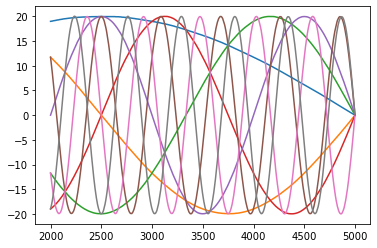

In [8]:
quick_plot(idxs, summed_sine_features, 2000, 5000, 0, 5); quick_plot(idxs, summed_sine_features, 2000, 5000, -4, -1); 

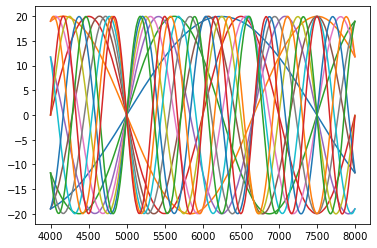

In [9]:
quick_plot(idxs, summed_sine_features, 4_000, 8_000, 1, 15)

At this point, assigning arbitrary `datetimes` to the indices would recreate the Spacetimeformer toy dataset. However, we need a very large dataset to test long-sequence models, and this pattern does not seem interesting enough over millions of timesteps.

## Long-Sequence Dataset with Multiple Pattern Resolutions

We create a net positive or negative trend for every variable to make sure the dataset is non-stationary.

In [10]:
global_trends = ((((np.random.random(size=(1, NUM_VARS)) - .5))) / (LENGTH) * idxs).astype(np.float16)

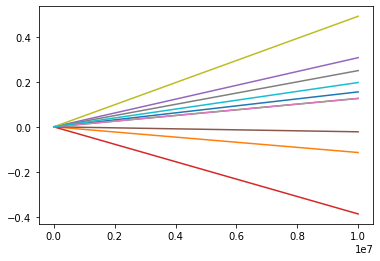

In [11]:
quick_plot(idxs, global_trends, 0, LENGTH, 0, 10)

Next we add "seasonal" patterns with periods >> the dependent sine waves. The seasonal effect has a random lag or offset for each varible.

In [12]:
offset = np.random.randint(low=-LENGTH // 4, high=LENGTH // 4, size=(1, NUM_VARS))
period = np.random.randint(low=4, high=8, size=(1, NUM_VARS))

In [13]:
semiglobal_trends = np.sin((idxs - offset) * (period * math.pi / LENGTH)).astype(np.float16)

We generate random noise where each variable has a slighly different distribution.

In [14]:
random_vars = np.random.random(NUM_VARS)

In [15]:
random_noise = np.random.normal(loc=np.zeros_like(random_vars), scale=random_vars, size=(LENGTH, NUM_VARS)).astype(np.float16)
#random_walks = np.cumsum(random_noise, axis=0)

Now we assign indices to calendar dates. We choose minute intervals so that a 10M length dataset spans about 20 years.

In [16]:
times = []
t = datetime.datetime(year=2000, month=1, day=1, hour=0, minute=0, second=0)
for i in range(LENGTH):
  t += datetime.timedelta(minutes=1)
  times.append(t)
times = np.array(times, dtype=np.datetime64)

Create the final dataset by summing four patterns of increasing resolution:
1. non-stationary trends (spanning entire datasaet)
2. periodic "seasonal" trends (spanning multiple years)
3. dependent sine wave patterns (spanning thousands of minutes)
4. pure random noise

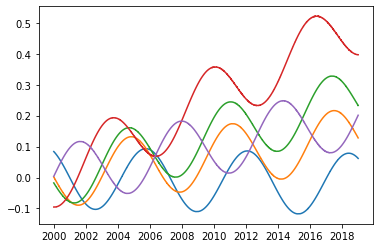

In [17]:
quick_plot(times, global_trends + .1 * semiglobal_trends, 0, LENGTH, 5, 10)

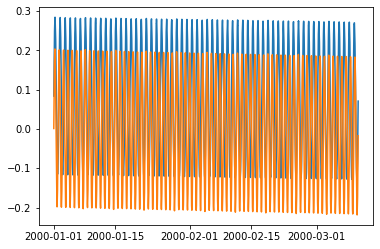

In [18]:
quick_plot(times, global_trends + .1 * semiglobal_trends + .01 * summed_sine_features, 0, LENGTH // 100, 5, 7)

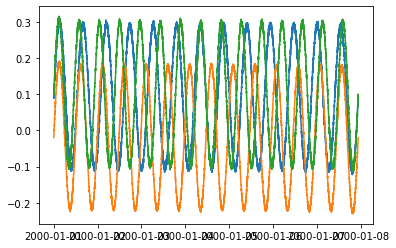

In [19]:
quick_plot(times, global_trends + .1 * semiglobal_trends + 0.01 * summed_sine_features + .005 * random_noise, 0, 10_000, 12, 15)

In [20]:
ts = 5. * (global_trends + .1 * semiglobal_trends + .01 * summed_sine_features + 5e-3 * random_noise)

In [21]:
df_dict = {f"y{i}":ts[:, i] for i in range(NUM_VARS)}; df_dict["Datetime"] = times

In [22]:
df = pd.DataFrame(df_dict); df

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y11,y12,y13,y14,y15,y16,y17,y18,y19,Datetime
0,-0.497070,0.395996,-0.219971,-0.484375,0.467285,0.419678,0.004509,-0.104980,-0.476318,0.014610,...,0.192627,0.476562,-0.098755,0.520020,-0.306152,-0.071167,-0.324463,0.236572,-0.191772,2000-01-01 00:01:00
1,-0.519531,0.429932,-0.208252,-0.477539,0.458740,0.422852,0.029907,-0.073181,-0.473877,0.022034,...,0.244873,0.467529,-0.086426,0.517090,-0.296875,-0.057800,-0.326904,0.250244,-0.226074,2000-01-01 00:02:00
2,-0.500977,0.405029,-0.214600,-0.493164,0.479980,0.427734,0.025955,-0.076416,-0.468262,0.035797,...,0.242920,0.443115,-0.066589,0.494385,-0.292236,-0.046051,-0.238770,0.270508,-0.197632,2000-01-01 00:03:00
3,-0.497070,0.435791,-0.212280,-0.488770,0.477051,0.431152,0.009811,-0.035065,-0.461182,0.042664,...,0.229492,0.473633,-0.065796,0.534180,-0.279785,-0.034302,-0.282471,0.276123,-0.182129,2000-01-01 00:04:00
4,-0.511719,0.430908,-0.202515,-0.473877,0.474121,0.437012,0.063354,-0.084473,-0.451660,0.045807,...,0.269043,0.518066,-0.057800,0.519043,-0.265869,-0.024597,-0.241089,0.291992,-0.166016,2000-01-01 00:05:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,0.259521,-0.993164,0.402588,-2.445312,1.982422,0.288330,0.593750,1.095703,1.957031,0.974121,...,-0.262207,-2.722656,0.681641,-0.878418,1.160156,-1.960938,-2.273438,1.109375,0.118103,2019-01-05 10:36:00
9999996,0.291504,-0.958008,0.396973,-2.423828,2.003906,0.293457,0.656738,1.155273,1.964844,0.977539,...,-0.293945,-2.716797,0.672852,-0.883301,1.161133,-1.953125,-2.248047,1.121094,0.141846,2019-01-05 10:37:00
9999997,0.274414,-1.041016,0.403076,-2.439453,1.998047,0.296387,0.635254,1.187500,1.962891,0.988770,...,-0.261230,-2.644531,0.685547,-0.833008,1.185547,-1.941406,-2.244141,1.140625,0.167725,2019-01-05 10:38:00
9999998,0.272461,-1.045898,0.410645,-2.433594,2.000000,0.302246,0.650391,1.161133,1.968750,0.988770,...,-0.251465,-2.697266,0.706055,-0.822266,1.192383,-1.927734,-2.218750,1.151367,0.171997,2019-01-05 10:39:00


In [23]:
df.to_csv("synthetic_lr_dset.csv", index=False)